In [1]:
%matplotlib inline

In [21]:
import numpy as np
import pylab as plt
import os
import ConfigParser
from glob import glob

In [3]:
def read_config(config_path):
    def as_dict(config):
        d = dict(config._sections)
        for k in d:
            d[k] = dict(config._defaults, **d[k])
            d[k].pop('__name__', None)
        return d
    
    config = ConfigParser.RawConfigParser()
    config.optionxform = str
    config.read(config_path)
    res = as_dict(config)
    return res

In [4]:
data_dir = '/diskmnt/a/makov/yaivan/MMC_1/_tmp/nrecon/bh_92_rc_20/'
file_name = os.path.join(data_dir, 'MMC1_2.82um__rec0960.png')
data_config = os.path.join(data_dir, 'MMC1_2.82um__rec.log')

data = plt.imread(file_name)
data=data[...,0]
print(data.shape)

(4000, 4000)


In [5]:
config = read_config(data_config)

d_min = config['Reconstruction']['Minimum for CS to Image Conversion']
d_min = float(d_min)

d_max = config['Reconstruction']['Maximum for CS to Image Conversion']
d_max = float(d_max)

print(d_min, d_max)

(-0.18, 0.52)


In [10]:
data = data.astype('float32')
data = (data-data.min())/(data.max()-data.min())*(d_max-d_min)+d_min

assert(data.shape[0]==data.shape[1])
radius = data.shape[0]/2+10

X,Y = np.meshgrid(np.arange(data.shape[0])-data.shape[0]/2.,np.arange(data.shape[1])-data.shape[1]/2.)
disk_mask_big = (X*X+Y*Y)<radius*radius 

data_zero = data.copy()
data_zero[disk_mask_big>0.5] = 0
data_zero[disk_mask_big<=0.5] = 1

radius = data.shape[0]/2-10

disk_mask_small = (X*X+Y*Y)<radius*radius

data_not_zero = data.copy()
data_not_zero[disk_mask_small<0.5] = 0

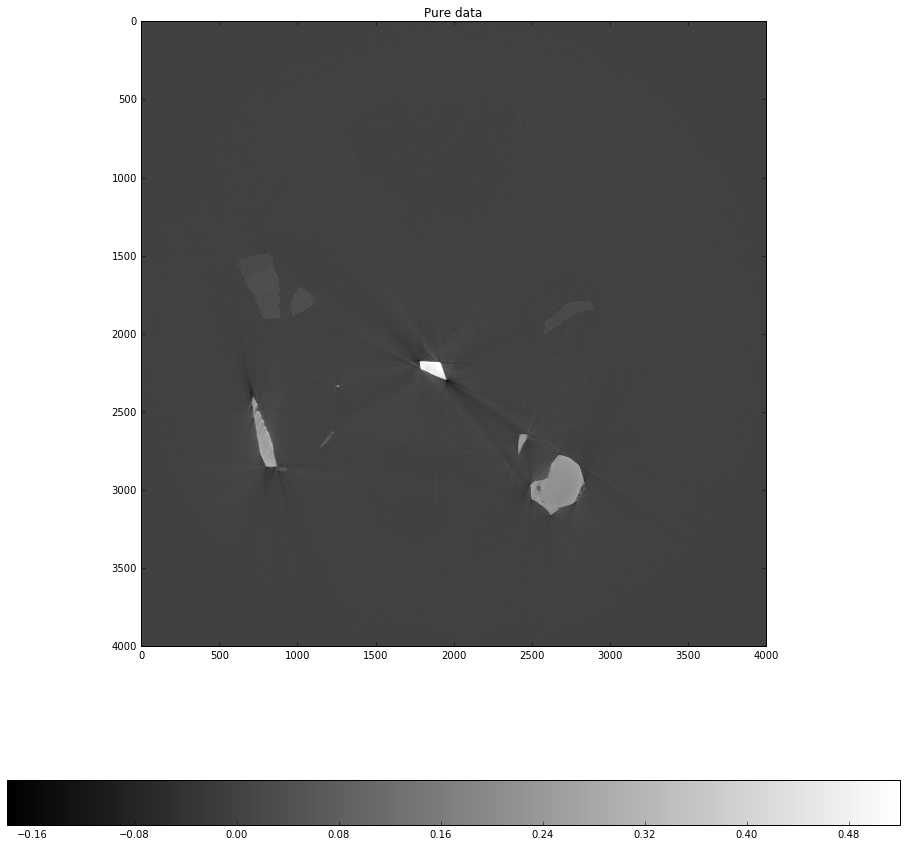

In [11]:
plt.figure(figsize=(16,16))
plt.title('Pure data')
plt.imshow(data, cmap=plt.cm.gray)
plt.colorbar(orientation='horizontal')

In [12]:
x = data_zero
x = set(x.flatten())
print 'Values outside disk: ', x
print 'Image discrtisation value: ', (d_max-d_min)/256

Values outside disk:  set([0.0, 1.0])
Image discrtisation value:  0.002734375


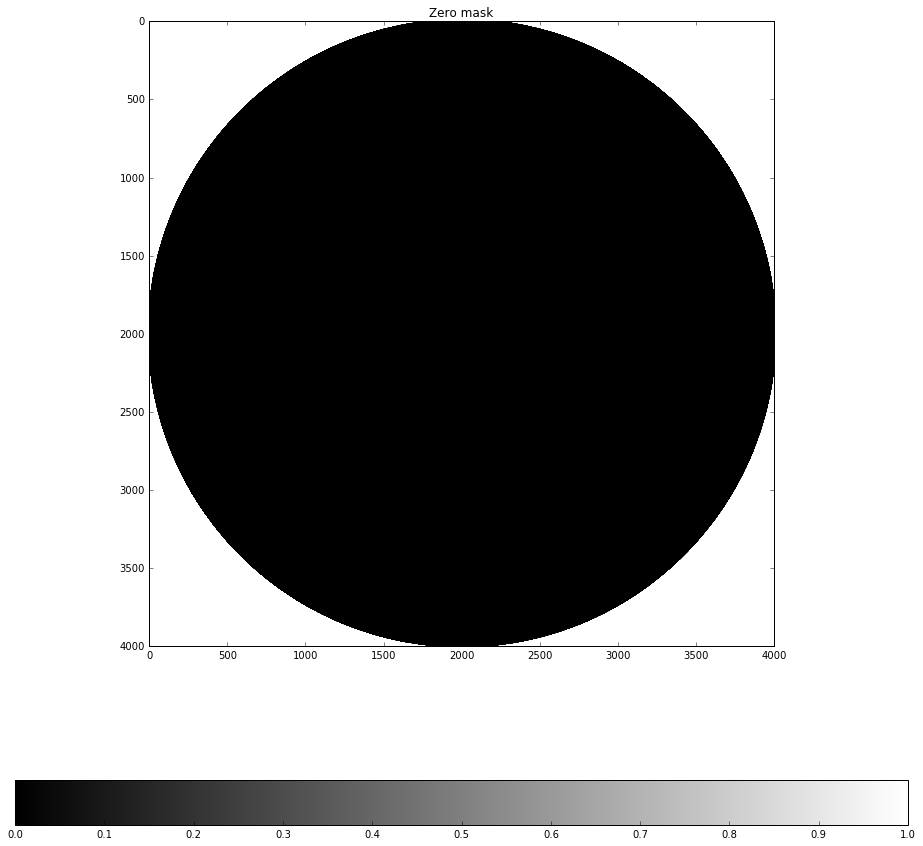

In [13]:
plt.figure(figsize=(16,16))
plt.title('Zero mask')
plt.imshow(data_zero, cmap=plt.cm.gray)
plt.colorbar(orientation='horizontal')

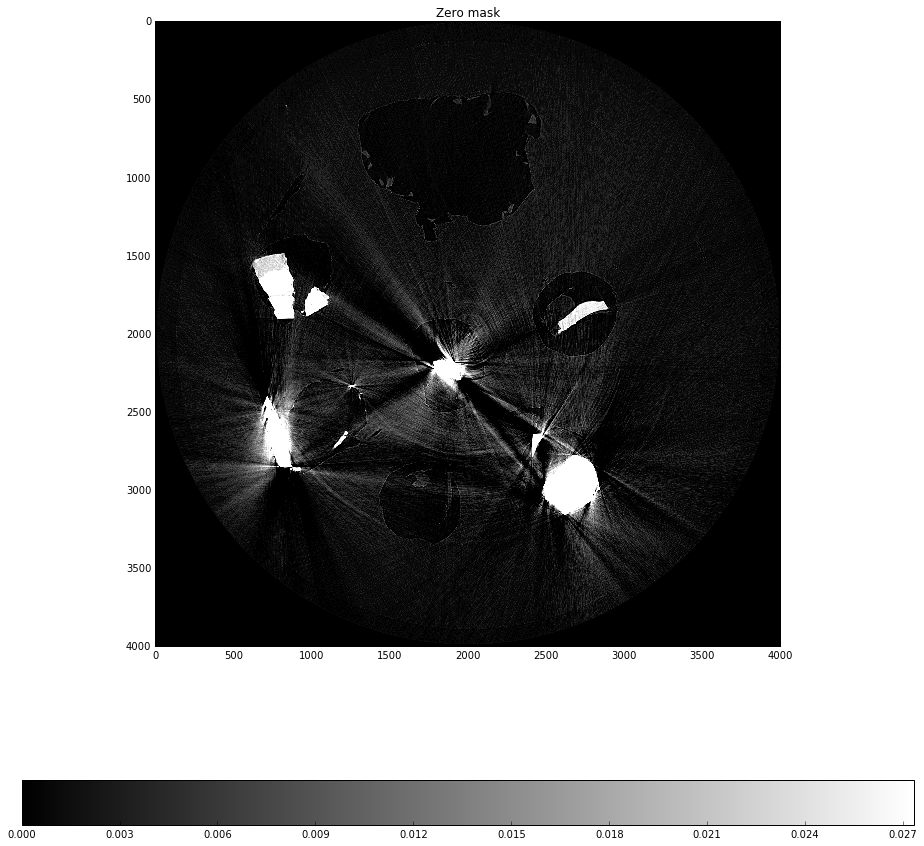

In [15]:
plt.figure(figsize=(16,16))
plt.title('Zero mask')
plt.imshow(data_not_zero, cmap=plt.cm.gray, vmin=0, vmax=(d_max-d_min)/256*10)
plt.colorbar(orientation='horizontal')

In [16]:
zeros_mask = plt.imread(
    '/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS.png')[...,0]

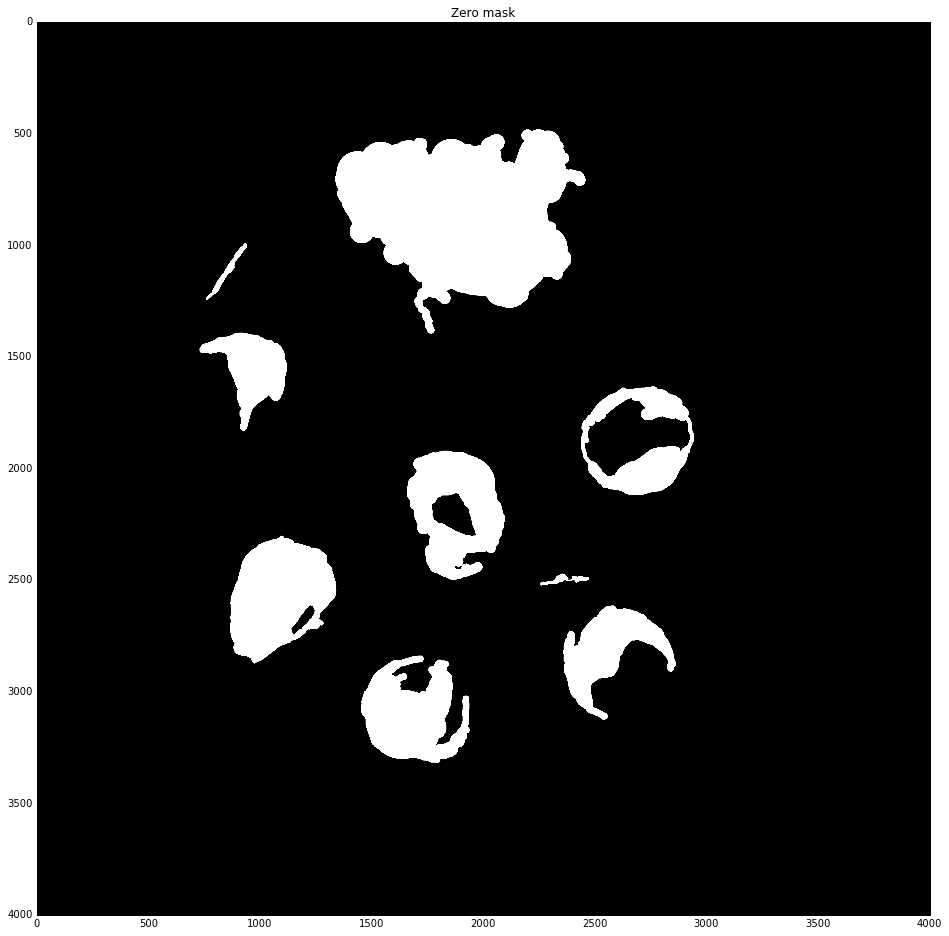

In [17]:
plt.figure(figsize=(16,16))
plt.title('Zero mask')
plt.imshow(zeros_mask, cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
# plt.savefig('mask.png')

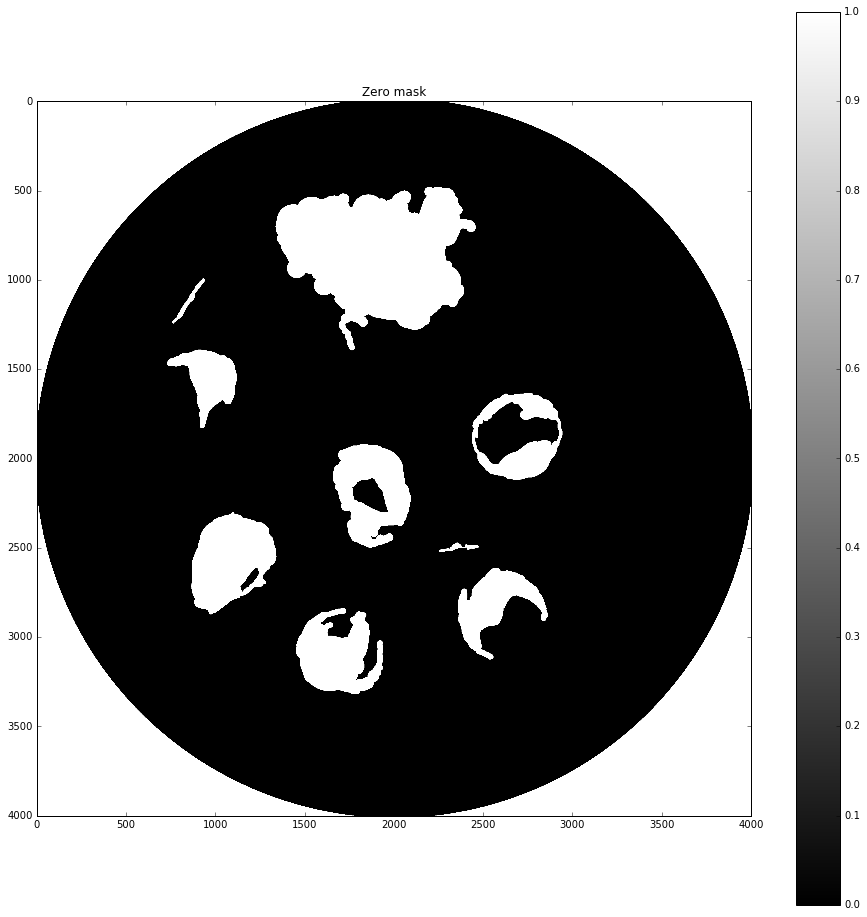

In [18]:
plt.figure(figsize=(16,16))
plt.title('Zero mask')
plt.imshow(data_zero+zeros_mask, cmap=plt.cm.gray)
plt.colorbar()

In [19]:
plt.imsave('/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS_CONERS.png',
          data_zero+zeros_mask, cmap=plt.cm.gray)

In [16]:
data_zeros = data[zeros_mask>0]

In [17]:
mu2=data_zeros.mean()**2
d=np.mean(data_zeros**2)

In [22]:
# data_dirs = glob('/diskmnt/storage0/nrecon/bh_*')
data_dirs = glob('/diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_*')
print len(data_dirs)

70


In [23]:
!ls {data_dirs[0]}

MMC1_2.82um__rec0960_astra_sart.png  MMC1_2.82um__rec.log


In [53]:
json_config = {'mask_image': '/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS_CONERS.png',
         'data_image': '/diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10/MMC1_2.82um__rec0960_astra_sart.png',
         'tomo_log': '/diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10/MMC1_2.82um__rec.log'}

In [54]:
import scipy.ndimage.measurements
import logging
import ConfigParser

LOG_FILENAME = 'astra_rec.out'

my_logger = logging.getLogger('')
my_logger.setLevel(logging.DEBUG)
handler = logging.handlers.RotatingFileHandler(
    LOG_FILENAME,  maxBytes=1e5, backupCount=5)
formatter = logging.Formatter('%(asctime)-15s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)

my_logger.addHandler(handler)

def read_config(config_path):
    def as_dict(config):
        d = dict(config._sections)
        for k in d:
            d[k] = dict(config._defaults, **d[k])
            d[k].pop('__name__', None)
        return d
    
    config = ConfigParser.RawConfigParser()
    config.optionxform = str
    config.read(config_path)
    res = as_dict(config)
    return res

def read_params(config):
    logging.info('Input tomo_log: {}'.format(config))
    mask_file = config['mask_image']
    if not os.path.exists(mask_file):
        logging.error('Mask image not exists: {}'.format(mask_file))
        raise IOError('Mask image not exists: {}'.format(mask_file))
    else:
        logging.info('Mask image found: {}'.format(mask_file))
        
    data_file = config['data_image']
    if not os.path.exists(mask_file):
        logging.error('Data image not exists: {}'.format(data_file))
        raise IOError('Data image not exists: {}'.format(data_file))
    else:
        logging.info('Data image found: {}'.format(data_file))
    
    tomolog_file = config['tomo_log']
    if not os.path.exists(mask_file):
        log.error('Tomo log not exists: {}'.format(tomolog_file))
        raise IOError('Tomo log not exists: {}'.format(tomolog_file))
    else:
        logging.info('Tomo log found: {}'.format(tomolog_file))
                      
    zeros_mask = plt.imread(mask_file)
    if len(zeros_mask.shape) == 3:
        zeros_mask = zeros_mask[...,0]
    elif not len(zeros_mask.shape) == 2:
        logging.error('Wrong zeros mask dimensions number. Requied 2 or 3, given {}'.format(len(zeros_mask.shape)))
        raise ValueError('Wrong zeros mask dimensions number. Requied 2 or 3, given {}'.format(len(zeros_mask.shape))) 
        
    data_image = plt.imread(data_file)
    if len(data_image.shape) == 3:
        data_image =data_image[...,0]
    elif not len(data_image.shape) == 2:
        logging.error('Wrong data image dimensions number. Requied 2 or 3, given {}'.format(len(zeros_mask.shape)))
        raise ValueError('Wrong data image dimensions number. Requied 2 or 3, given {}'.format(len(zeros_mask.shape))) 
    
    config = read_config(tomolog_file)
    logging.info('Config: {}'.format(config))
    d_min = config['Reconstruction']['Minimum for CS to Image Conversion']
    d_min = float(d_min)
    d_max = config['Reconstruction']['Maximum for CS to Image Conversion']
    d_max = float(d_max)
    data = data_image /(data_image .max()-data_image .min())*(d_max-d_min)+d_min
    
    return data, zeros_mask, config

def calculate_background(data, zeros_mask):   
    labeled_mask, num_features = scipy.ndimage.measurements.label(zeros_mask)
    logging.info('Found regions: {}'.format(num_features-1))
    sigma = []
    for nf in range(num_features):
        if nf == 0 :
            continue
        
        data_constant = data[labeled_mask==nf]
        s = np.std(data_constant)
        sigma.append(s)
    logging.info('Sigmas for regions: {}'.format(sigma))
    std = np.mean(sigma)
    logging.info('Mean sigma for regions: {}'.format(std))
    mean_value = data.mean()
    logging.info('Mean reconstruction value for regions: {}'.format(mean_value))
    res = std/mean_value
    logging.info('Normalized sigma: {}'.format(res))
    return  res

def main():
    data, zeros_mask, config = read_params(json_config)
    calculate_background(data, zeros_mask)
    
main()

INFO:root:Input tomo_log: {'tomo_log': '/diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10/MMC1_2.82um__rec.log', 'data_image': '/diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10/MMC1_2.82um__rec0960_astra_sart.png', 'mask_image': '/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS_CONERS.png'}
INFO:root:Mask image found: /diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS_CONERS.png
INFO:root:Data image found: /diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10/MMC1_2.82um__rec0960_astra_sart.png
INFO:root:Tomo log found: /diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10/MMC1_2.82um__rec.log
INFO:root:Config: {'Reconstruction': {'Minimum for CS to Image Conversion': '-123.905', 'Ring Artifact Correction': '10', 'Maximum for CS to Image Conversion': '280.261', 'Beam Hardening Correction (%)': '60'}}
INFO:root:Found regions: 12
INFO:root:Sigmas for regions: [1.2623249, 1.3960401, 1.1254997, 1.4694213, 1.8340983, 1.955984,

In [45]:
zeros_mask = plt.imread(
    '/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS_CONERS.png')[...,0]

for d in data_dirs[0:1]:  
    print d,
#     file_name = os.path.join(d, 'MMC1_2.82um__rec0960.png')
    file_name = os.path.join(d, 'MMC1_2.82um__rec0960_astra_sart.png')
    data_config = os.path.join(d, 'MMC1_2.82um__rec.log')


    config = read_config(data_config)
    
    d_min = config['Reconstruction']['Minimum for CS to Image Conversion']
    d_min = float(d_min)

    d_max = config['Reconstruction']['Maximum for CS to Image Conversion']
    d_max = float(d_max)
    
    bh = config['Reconstruction']['Beam Hardening Correction (%)']
    bh = float(bh)
    
    rc = config['Reconstruction']['Ring Artifact Correction']
    rc = float(rc)
    
    
    
    data = plt.imread(file_name)
    data=data[...,0]
    
    calculate_background(data, zeros_mask)

/diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10 13
0.0252702


In [24]:
zeros_mask = plt.imread(
    '/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS_CONERS.png')[...,0]

res = []
for d in data_dirs[0:1]:  
    print d,
#     file_name = os.path.join(d, 'MMC1_2.82um__rec0960.png')
    file_name = os.path.join(d, 'MMC1_2.82um__rec0960_astra_sart.png')
    data_config = os.path.join(d, 'MMC1_2.82um__rec.log')


    config = read_config(data_config)
    
    d_min = config['Reconstruction']['Minimum for CS to Image Conversion']
    d_min = float(d_min)

    d_max = config['Reconstruction']['Maximum for CS to Image Conversion']
    d_max = float(d_max)
    
    bh = config['Reconstruction']['Beam Hardening Correction (%)']
    bh = float(bh)
    
    rc = config['Reconstruction']['Ring Artifact Correction']
    rc = float(rc)
    
    
    
    data = plt.imread(file_name)
    data=data[...,0]
    
    data_zeros = data[zeros_mask>0]
    
    mu2 = data_zeros.mean()**2
    d = np.mean(data_zeros**2)
    s = np.std(data_zeros)
    res.append([bh, rc, mu2, d ,s])
    
    print bh, rc, mu2, d, s

/diskmnt/a/makov/yaivan/MMC_1/_tmp/astra/bh_60_rc_10 60.0 10.0 0.0939861842026 0.094037 0.00712518


In [34]:
bhs = set([x[0] for x in res])
bhs = sorted(list(bhs))
print bhs

rcs = set([x[1] for x in res])
rcs = sorted(list(rcs))
print rcs

B,H = np.meshgrid(bhs, rcs)

M2 = np.zeros_like(B)
D = np.zeros_like(B)
S = np.zeros_like(B)
for ib, b in enumerate(B[0]):
    for ih, h in enumerate(H[:,0]):
        for r in res:
            if np.isclose(r[0], b) and np.isclose(r[1], h):
                M2[ih,ib] = r[2]
                D[ih,ib] = r[3]
                S[ih,ib] = r[4]
                break

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 92.0, 95.0, 98.0, 100.0]
[0.0, 5.0, 10.0, 15.0, 20.0]


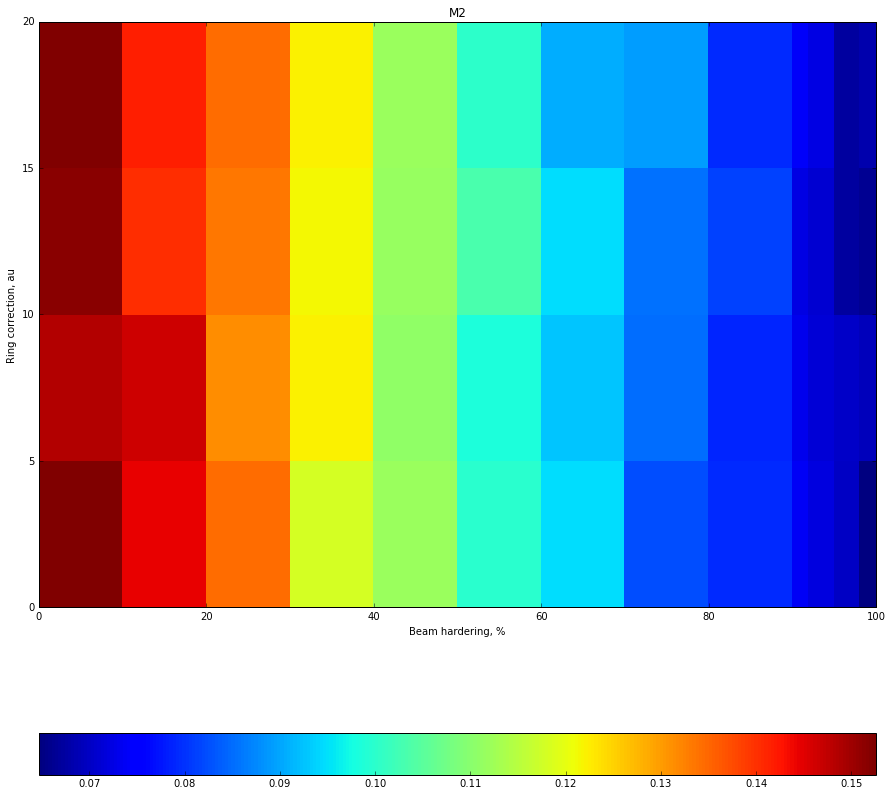

In [35]:
plt.figure(figsize=(15,15))
plt.title('M2')
plt.pcolor(B,H,M2)
plt.colorbar(orientation='horizontal');
plt.xlabel('Beam hardering, %')
plt.ylabel('Ring correction, au')
plt.savefig('M2.png')

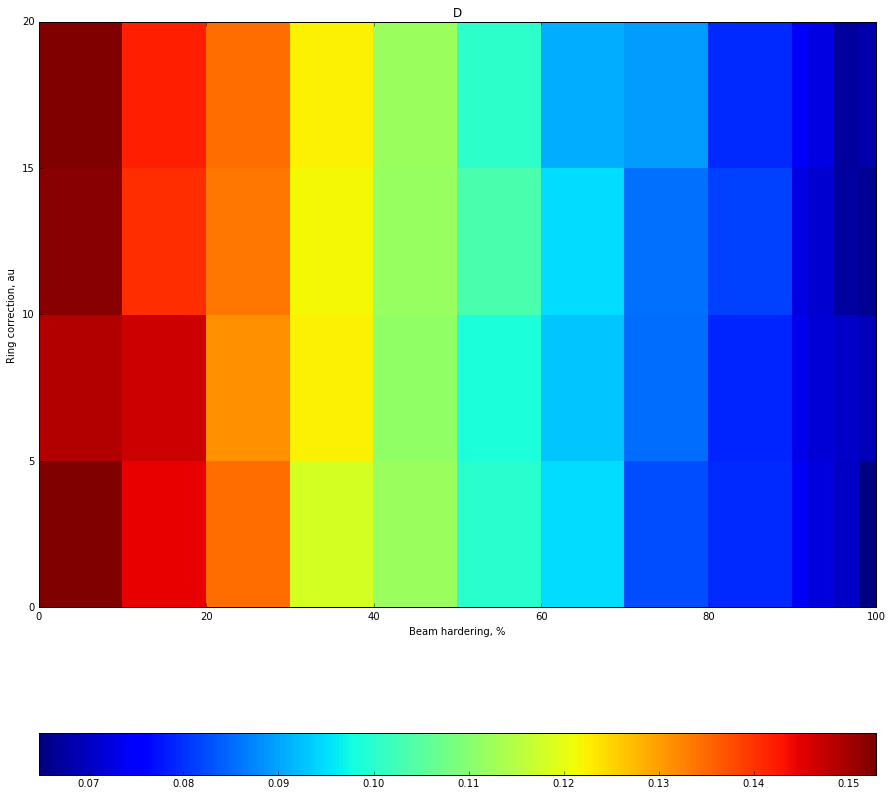

In [36]:
plt.figure(figsize=(15,15))
plt.title('D')
plt.pcolor(B,H,D)
plt.colorbar(orientation='horizontal');
plt.xlabel('Beam hardering, %')
plt.ylabel('Ring correction, au')
plt.savefig('D.png')

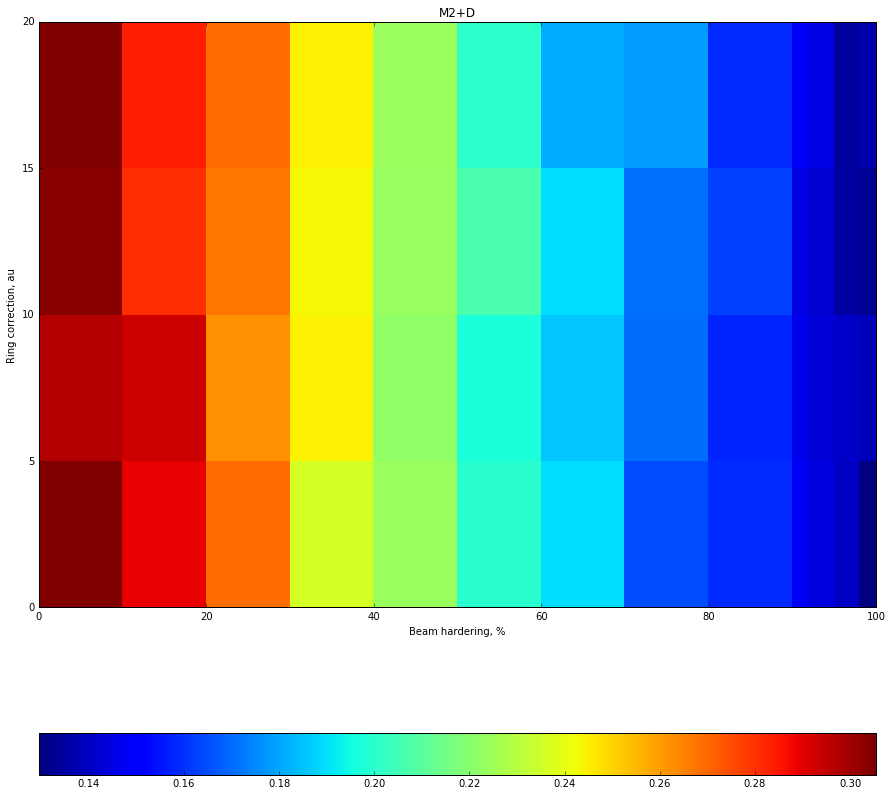

In [37]:
plt.figure(figsize=(15,15))
plt.title('M2+D')
plt.pcolor(B,H,M2+D)
plt.colorbar(orientation='horizontal');
plt.xlabel('Beam hardering, %')
plt.ylabel('Ring correction, au')
plt.savefig('M2_D.png')

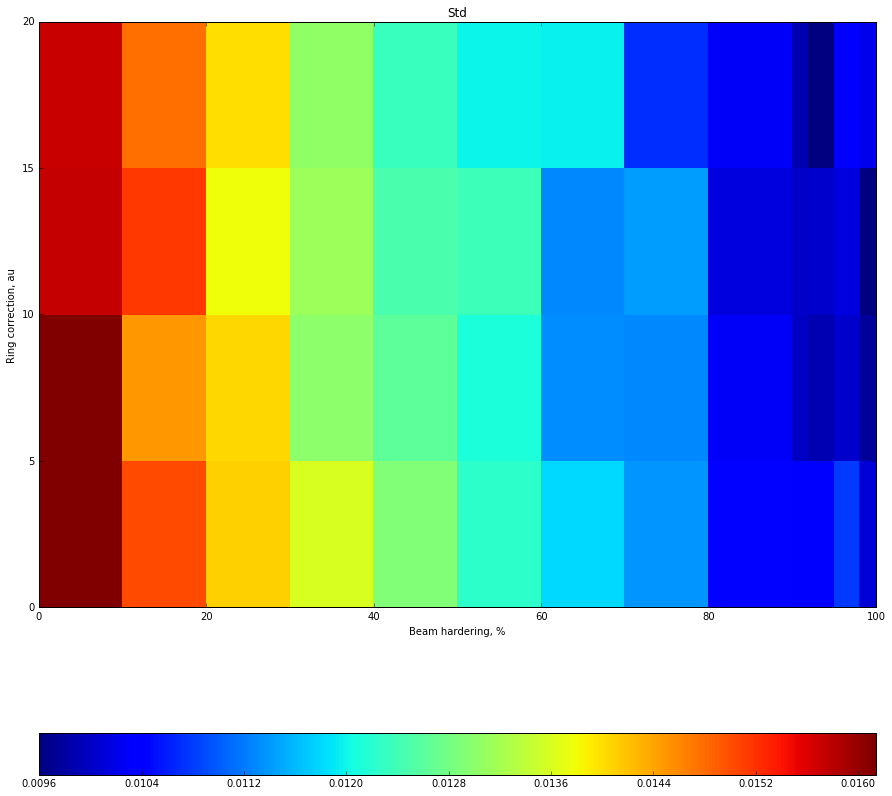

In [38]:
plt.figure(figsize=(15,15))
plt.title('Std')
plt.pcolor(B,H,S)
plt.colorbar(orientation='horizontal');
plt.xlabel('Beam hardering, %')
plt.ylabel('Ring correction, au')
plt.savefig('std.png')

In [78]:
np.std?

In [55]:
import json

In [58]:
with open('bg.json','w') as f:
    json.dump(json_config, f)

In [60]:
json.load?